##Прогнозирование оотока клиентов телеком оператора (построение улучшенной модели и ее валидация)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
#Загружаем датасет

url = 'https://drive.google.com/file/d/1_gvIy2MoOTeX4oEk8xaa_1Wo1wwnEjS-/view?usp=sharing'
url2 = 'https://drive.google.com/uc?id='+ url.split('/')[-2]
df = pd.read_csv(url2)
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
df["Churn"] = df["Churn"].astype("int64")
d = {"No": False, "Yes": True}
df["International plan"] = df["International plan"].map(d)
df["Voice mail plan"] = df["Voice mail plan"].map(d)


Чтобы оценивать результат с течением времени, было принято решение, ввести новый признак Lifetime - время от начала заключения договора до даты выгрузки данных. 

In [4]:
#Добавим новый временной признак Lifetime

np.random.seed(42)
n_churn = len(df[df['Churn']==1])
noise = df[df['Churn']==0]['Account length'].max() // 3
df['Lifetime'] = df['Account length']
df.loc[df['Churn']==1, ['Lifetime']] = df[df['Churn']==1]['Lifetime'] + pd.Series(np.round(np.random.uniform(0, noise, n_churn*8)))
df['Lifetime'] = df['Lifetime'].astype("int64")
df[df['Churn']==1].head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,Lifetime
10,IN,65,415,False,False,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,1,67
15,NY,161,415,False,False,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,1,176
21,CO,77,408,False,False,0,62.4,89,10.61,169.9,121,14.44,209.6,64,9.43,5.7,6,1.54,5,1,88
33,AZ,12,408,False,False,0,249.6,118,42.43,252.4,119,21.45,280.2,90,12.61,11.8,3,3.19,1,1,89
41,MD,135,408,True,True,41,173.1,85,29.43,203.9,107,17.33,122.2,78,5.50,14.6,15,3.94,0,1,175


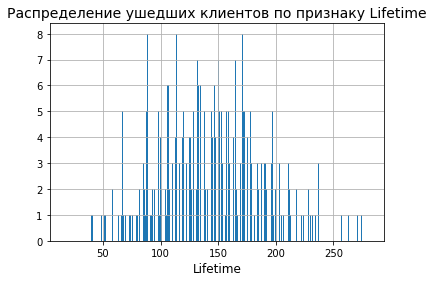

In [ ]:
#Распределение ушедших клиентов по признаку Lifetime

df[df['Churn']==1]['Lifetime'].hist(bins=n_churn)
plt.xlabel('Lifetime', fontsize=12)
plt.title('Распределение ушедших клиентов по признаку Lifetime', fontsize=14);

In [5]:
#Сортируем клиентов от самых старых до новых

df = df.sort_values(['Lifetime'], ascending=False)

In [ ]:
#Удаляем из признаков линейно-зависимые и штат
 
y = df['Churn']
X = df.drop(['Churn', 'State','Total day minutes','Total eve minutes','Total night minutes','Total intl minutes', 'Lifetime'], axis=1)

In [ ]:
#Разбиваем исходную выборку на тестовую и обучающую

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

##Построим новую базовую модель (случайный лес) на упорядоченных данных

Наш датасет был отсортирован по времени, поэтому потребовалось построить новую базовая модель. После этого были подобраны оптимальные параметры для случайного леса и бустинга.


In [ ]:
# Инициализируем случайный лес с максимальной длиной 4

rfc_base_model = RandomForestClassifier(max_depth=4, random_state=42, n_jobs=-1)

In [ ]:
#Обучаем случайный лес и оцениванием качество модели на тестовой выборке

rfc_base_model.fit(X_train, y_train)
pred_proba = rfc_base_model.predict_proba(X_test)
roc_score_rfc_base = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score_rfc_base)

roc на test 0.8819355346973687


In [ ]:
#Оцениванием качество модели методом кросс-валидации

cv_scores = cross_val_score(rfc_base_model, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
mean_roc_auc = np.mean(cv_scores)
cv_scores = cross_val_score(rfc_base_model, X_train, y_train, scoring='precision', cv=5, n_jobs=-1)
mean_precision = np.mean(cv_scores)
cv_scores = cross_val_score(rfc_base_model, X_train, y_train, scoring='recall', cv=5, n_jobs=-1)
mean_recall = np.mean(cv_scores)
print('mean roc_auc', mean_roc_auc)
print('mean precision', mean_precision)
print('mean recall', mean_recall)

mean roc_auc 0.9123981814534826
mean precision 0.8
mean recall 0.08640148011100832


##Улучшение модели: случайный лес

Проведем подбор параметров модели с помощью GridSearchCV.

In [ ]:
'''
grid = {'max_depth': [3, 4 ,5 ,6, 10, 13],
        'n_estimators': [100, 200, 300, 400],
        'criterion': ['gini', 'entropy']}
'''

In [ ]:
'''
rfc_model = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
clf = GridSearchCV(rfc_model, grid, n_jobs=-1, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=5)

clf.fit(X_train,y_train)
'''

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=42,
                                     

In [ ]:
'''
rfc_params = clf.best_params_
rfc_estimator = clf.best_estimator_
rfc_score = clf.best_score_
rfc_cv = clf.cv_results_
print(rfc_params)
print(rfc_estimator)
print(rfc_score)
#print(rfc_cv)
'''

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)
0.9292403091144095


Лучшее качество на кросс валидации 0.9292403091144095

In [ ]:
'''
pred_proba_rfc = rfc_estimator.predict_proba(X_test)
roc_score_rfc = roc_auc_score(y_test, pred_proba_rfc[:, 1])
print('roc на test', roc_score_rfc)
'''

roc на test 0.9005841042609224


Качество на тесте 0.9005841042609224

##Улучшение модели: бустинг

Проведем подбор параметров модели с помощью GridSearchCV.

In [ ]:
'''
grid = {'max_depth': [None, 3, 4 ,5 ,6],
        'learning_rate': [0 , 0.01, 0.1, 0.3],
        'n_estimators': [100, 200, 300, 500],
        'reg_alpha': [0 , 0.01, 0.1, 0.3],
        'reg_lambda': [0 , 0.01, 0.1, 0.3],}
'''
    


In [ ]:
'''
xg_model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42) 

clf = GridSearchCV(xg_model, grid, n_jobs=-1, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=5)

clf.fit(X_train, y_train)
'''

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 556 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 646 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1366 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1770 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2662 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 3942 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 4392 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 5366 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 5888 tasks      | e

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0, 0.01, 0.1, 0.3],
                         'max_depth': [None, 3, 4, 5, 6],
                         'n_estimators': [100, 200, 300,

In [ ]:
'''
xg_params = clf.best_params_
xg_estimator = clf.best_estimator_
xg_score = clf.best_score_
xg_cv = clf.cv_results_
print(xg_params)
print(xg_estimator)
print(xg_score)
#print(xg_cv)
'''

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.3, 'reg_lambda': 0.01}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.9312792372222439


Лучшее качество на кросс валидации 0.9312792372222439

In [ ]:
'''
pred_proba_xg = xg_estimator.predict_proba(X_test)
roc_score_xg = roc_auc_score(y_test, pred_proba_xg[:, 1])
print('roc на test', roc_score_xg)
'''

roc на test 0.9074858757062145


Качество на тесте 0.9074858757062145

##Улучшение модели: используем признак State для бустинга

In [ ]:
state_enc = LabelEncoder()
df["State"] = state_enc.fit_transform(df["State"])

In [ ]:
#Удаляем из признаков линейно-зависимые и Lifetime
 
y = df['Churn']
X = df.drop(['Churn', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes', 'Lifetime'], axis=1)

In [ ]:
#Разбиваем исходную выборку на тестовую и обучающую

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Проведем подбор параметров модели с помощью GridSearchCV.

In [ ]:
'''
grid = {'max_depth': [None, 3, 4 ,5 ,6],
        'learning_rate': [0 , 0.01, 0.1, 0.3],
        'n_estimators': [100, 200, 300, 500],
        'reg_alpha': [0 , 0.01, 0.1, 0.3],
        'reg_lambda': [0 , 0.01, 0.1, 0.3],}
''' 

In [ ]:
'''
xg_model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42) 

clf = GridSearchCV(xg_model, grid, n_jobs=-1, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=5)

clf.fit(X_train, y_train)
'''

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1526 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2210 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2552 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2930 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 3722 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4172 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4658 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 5558 tasks      | e

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0, 0.01, 0.1, 0.3],
                         'max_depth': [None, 3, 4, 5, 6],
                         'n_estimators': [100, 200, 300,

In [ ]:
'''
xg_params = clf.best_params_
xg_estimator = clf.best_estimator_
xg_score = clf.best_score_
xg_cv = clf.cv_results_
print(xg_params)
print(xg_estimator)
print(xg_score)
#print(xg_cv)
'''

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.01}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.9325733087787194


Лучшее качество на кросс валидации 0.9325733087787194

In [ ]:
'''
pred_proba_xg = xg_estimator.predict_proba(X_test)
roc_score_xg = roc_auc_score(y_test, pred_proba_xg[:, 1])
print('roc на test', roc_score_xg)
'''

roc на test 0.9094919756004232


Качество на тесте 0.9094919756004232

##Валидация модели

Бустинг при добавлении признака State показал лучшее качество, используем эту модель.

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, reg_alpha=0.1, reg_lambda=0.01)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Оценим качество модели на тестовой выборке

pred_proba_xgb = xgb_model.predict_proba(X_test)
roc_score_xgb = roc_auc_score(y_test, pred_proba_xgb[:, 1])
print('roc на test', roc_score_xgb)

roc на test 0.9019233799266212


In [ ]:
#Оценим качество модели на ткросс валидации

cv_scores_roc_auc = cross_val_score(xgb_model, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
mean_roc_auc = np.mean(cv_scores_roc_auc)
cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='precision', cv=5, n_jobs=-1)
mean_precision = np.mean(cv_scores)
cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='recall', cv=5, n_jobs=-1)
mean_recall = np.mean(cv_scores)

print('mean roc_auc', mean_roc_auc)
print('mean precision', mean_precision)
print('mean recall', mean_recall)


mean roc_auc 0.9282482369506578
mean precision 0.8938938254727729
mean recall 0.6767807585568917


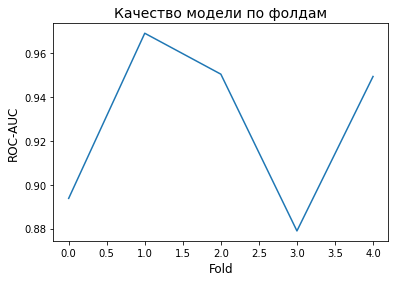

In [ ]:
#Изобразим изменение качества модели по фолдам

pd.Series(cv_scores_roc_auc).plot()
plt.xlabel('Fold', fontsize=12)
plt.ylabel('ROC-AUC', fontsize=12)
plt.title('Качество модели по фолдам', fontsize=14);

Мы наблюдаем несущественное изменение качества модели по фолдам относительно среднего значения. Модель ведет себя достаточно стабильно.

##Важность признаков,  интерпретируемость

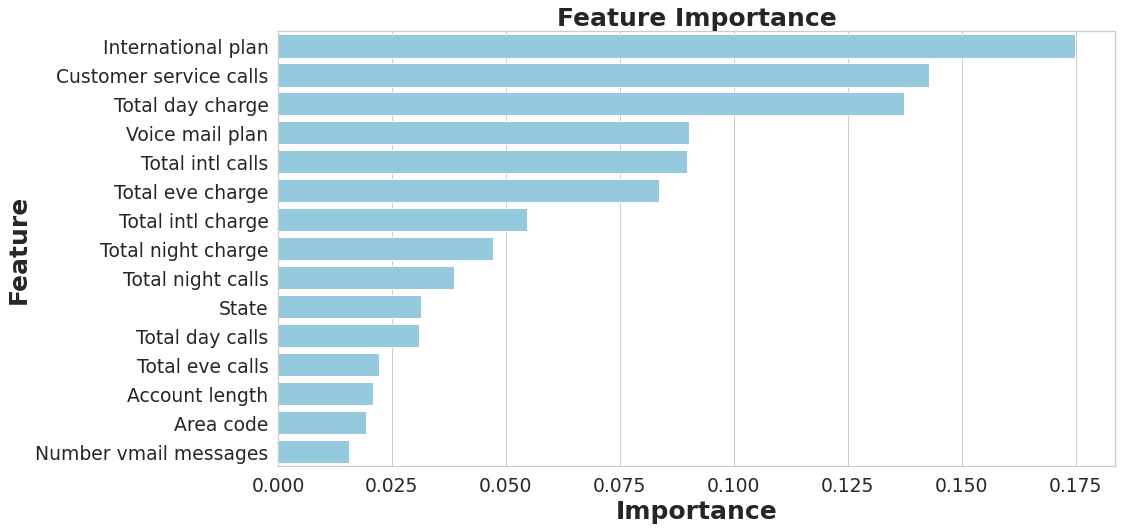

In [ ]:
xgb_importances = pd.Series(xgb_model.feature_importances_)
xgb_features = X.columns
feats = {}

for feature, importance in zip(xgb_features, xgb_importances):
    feats[feature] = importance
xgb_viz = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
xgb_viz = xgb_viz.sort_values(by='Importance', ascending=False)
xgb_viz = xgb_viz.reset_index()
xgb_viz = xgb_viz.rename(columns={'index': 'Feature'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.barplot(x=xgb_viz['Importance'], y=xgb_viz['Feature'], data=xgb_viz, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Feature', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

Посмотрим на связь признака International plan с оттоком. Когда роуминг подключен, доля оттока намного выше.

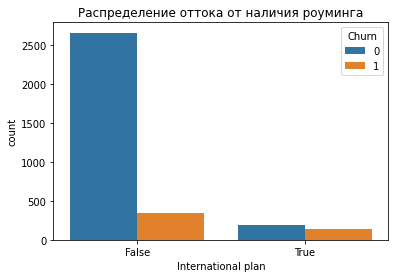

In [12]:
sns.countplot(x="International plan", hue="Churn", data=df)
plt.title('Распределение оттока от наличия роуминга');

Посмотрим на распределение числа обращений в сервисный центр. Доля оттока сильно возрастает начиная с 4 звонков в сервисный центр.

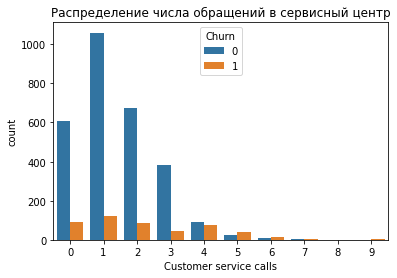

In [15]:
sns.countplot(x="Customer service calls", hue="Churn", data=df)
plt.title('Распределение числа обращений в сервисный центр');

Посмотрим на распределение суммы оплаты услуг днем среди лояльных/ушедших. 
В среднем ушедшие клиенты больше пользуются связью. Предположительно это связано с высокой стоимостью тарифа либо качеством обслужиания. Компании следует провести дополнительный анализ возможных причин.

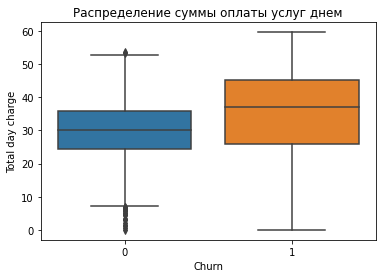

In [17]:
sns.boxplot(x="Churn", y="Total day charge", data=df)
plt.title('Распределение суммы оплаты услуг днем');

Посмотрим на связь признака Voice mail plan с оттоком. Нет сильной связи, как в случае с роумингом.

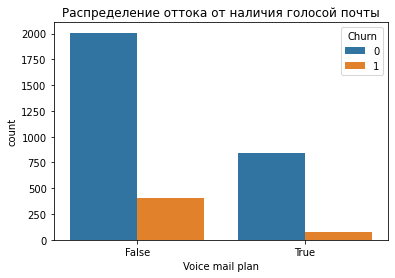

In [18]:
sns.countplot(x="Voice mail plan", hue="Churn", data=df)
plt.title('Распределение оттока от наличия голосой почты');

##Оценка работы модели на различных сегментах пользователей

Сегменты можно разделить по трем критериям:

*   География - в нашем датасете это штаты
*   Демография - у нас нет таких данных
*   Поведение - дневные звонки, голосовая почта, длительность обслуживания


**Проведем оценку качества модели по штатам.**

In [ ]:
idx_df = len(df) // 2
df_train = df[:idx_df].drop(['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes', 'Lifetime'], axis=1)
df_test = df[idx_df:].drop(['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes', 'Lifetime'], axis=1)

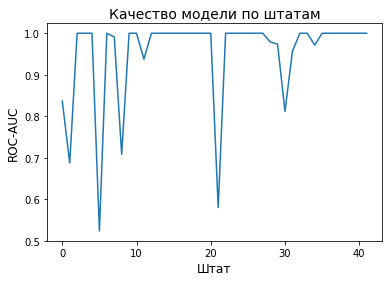

In [ ]:
roc_scores = []
for state in df_test['State'].unique():

    X_test_state = df_test[df_test['State']==state].drop(['Churn'], axis=1)
    y_test_state = df_test[df_test['State']==state]['Churn']
    pred_proba = xgb_model.predict_proba(X_test_state)
    try:
        roc_scores.append(roc_auc_score(y_test_state, pred_proba[:, 1]))
    except ValueError:
        pass
    
pd.Series(roc_scores).plot()
plt.xlabel('Штат', fontsize=12)
plt.ylabel('ROC-AUC', fontsize=12)
plt.title('Качество модели по штатам', fontsize=14);

У нас недостаточно данных для качественной оценки по штатам. В некоторые штаты не попали оба класса отток/не оток.

**Проведем оценку качества модели по наличию голосовой почты.**

In [ ]:
X_voice_mail_test = df_test[df_test['Voice mail plan']==False].drop(['Churn'],axis=1)
y_voice_mail_test = df_test[df_test['Voice mail plan']==False]['Churn']

In [ ]:
pred_proba_xgb_voice_mail = xgb_model.predict_proba(X_voice_mail_test)
roc_score_xgb_voice_mail = roc_auc_score(y_voice_mail_test, pred_proba_xgb_voice_mail[:, 1])
print('roc на test', roc_score_xgb_voice_mail)

roc на test 0.953889093685818


При отсутствии голосой почты качество модели выше среднего.

In [ ]:
X_voice_mail_test = df_test[df_test['Voice mail plan']==True].drop(['Churn'],axis=1)
y_voice_mail_test = df_test[df_test['Voice mail plan']==True]['Churn']

In [ ]:
pred_proba_xgb_voice_mail = xgb_model.predict_proba(X_voice_mail_test)
roc_score_xgb_voice_mail = roc_auc_score(y_voice_mail_test, pred_proba_xgb_voice_mail[:, 1])
print('roc на test', roc_score_xgb_voice_mail)

roc на test 0.8752759381898455


При наличии голосой почты качество модели ниже среднего.

**Проведем оценку качества модели по оплате за дневные звонки.**

In [ ]:
X_day_charge_test = df_test[df_test['Total day charge'] > 26].drop(['Churn'],axis=1)
y_day_charge_test = df_test[df_test['Total day charge'] > 26]['Churn']

In [ ]:
pred_proba_xgb_day_charge = xgb_model.predict_proba(X_day_charge_test)
roc_score_xgb_day_charge = roc_auc_score(y_day_charge_test, pred_proba_xgb_day_charge[:, 1])
print('roc на test', roc_score_xgb_day_charge)

roc на test 0.9571299871299872


При оплате за дневные звонки выше 26 у.е. качество модели выше среднего.

In [ ]:
X_day_charge_test = df_test[df_test['Total day charge'] <= 26].drop(['Churn'],axis=1)
y_day_charge_test = df_test[df_test['Total day charge'] <= 26]['Churn']

In [ ]:
pred_proba_xgb_day_charge = xgb_model.predict_proba(X_day_charge_test)
roc_score_xgb_day_charge = roc_auc_score(y_day_charge_test, pred_proba_xgb_day_charge[:, 1])
print('roc на test', roc_score_xgb_day_charge)

roc на test 0.902281239359891


При оплате за дневные звонки до 26 у.е. качество модели остается средним.

**Проведем оценку качества модели по длительности обслуживания.**

In [ ]:
X_account_length_test = df_test[df_test['Account length'] > 90].drop(['Churn'],axis=1)
y_account_length_test = df_test[df_test['Account length'] > 90]['Churn']

In [ ]:
pred_proba_xgb_account_length = xgb_model.predict_proba(X_account_length_test)
roc_score_xgb_account_length = roc_auc_score(y_account_length_test, pred_proba_xgb_account_length[:, 1])
print('roc на test', roc_score_xgb_account_length)

roc на test 0.8364457831325302


При обслуживании более 90 дней качество модели ниже среднего.

In [ ]:
X_account_length_test = df_test[df_test['Account length'] <= 90].drop(['Churn'],axis=1)
y_account_length_test = df_test[df_test['Account length'] <= 90]['Churn']

In [ ]:
pred_proba_xgb_account_length = xgb_model.predict_proba(X_account_length_test)
roc_score_xgb_account_length = roc_auc_score(y_account_length_test, pred_proba_xgb_account_length[:, 1])
print('roc на test', roc_score_xgb_account_length)

roc на test 0.9554550318595263


При обслуживании до 90 дней качество модели выше среднего.

##Деградация модели

Будем последовательно оценивать изменение качества модели на новых данных по 2,5%.

In [ ]:
#Разобьем тестовый набор данных на 20 частей

n_part = 20
n_observ = len(y_test) // n_part

for part in range(n_part - 1):
    globals()[f'X_test{part}'] = X_test[part * n_observ : (part + 1) * n_observ]
    globals()[f'y_test{part}'] = y_test[part * n_observ : (part + 1) * n_observ]
globals()[f'X_test{part + 1}'] = X_test[(part + 1) * n_observ :]
globals()[f'y_test{part + 1}'] = y_test[(part + 1) * n_observ :]

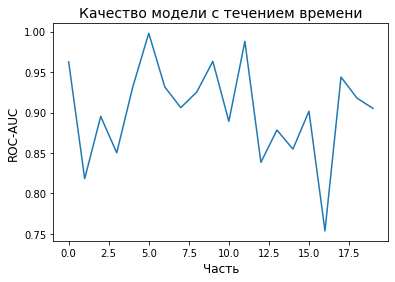

In [ ]:
#Последовательно оценим качество модели на полученных наборах данных

roc_scores = []
for part in range(n_part):
    pred_proba = xgb_model.predict_proba(globals()[f'X_test{part}'])
    roc_score = roc_auc_score(globals()[f'y_test{part}'], pred_proba[:, 1])
    roc_scores.append(roc_score)

pd.Series(roc_scores).plot()
plt.xlabel('Часть', fontsize=12)
plt.ylabel('ROC-AUC', fontsize=12)
plt.title('Качество модели с течением времени', fontsize=14);

In [ ]:
df['Lifetime'].describe()

count    3333.000000
mean      106.845785
std        43.455400
min         1.000000
25%        77.000000
50%       105.000000
75%       135.000000
max       281.000000
Name: Lifetime, dtype: float64

Для обучения модели были взяты данные с 281 дня по 105, для оценки деградаци со 105 по 1. За данный период тенденция падения качества модели не обнаружена.